# Technical Assessment

## Overview of this notebook

- **Author:** 
    - Alex Sandro Alves de Araujo (alex.fate2000@gmail.com).
- **Problem formulation:**
    - Classify SMS text messages as being ham (ok) or spam (blocked).
    - Python programming language.
- **Raw data exploration:**
    - Most of words seem to come from Brazilian Portuguese.
    - A lot of digits, phone numbers, codes, websites and special characters.
    - 6000 instances with one line and multi-line strings.
    - Without null fields.
    - We can see that the problem is unbalanced: 1500 (25 %) are spam messages and 4500 (75 %) are ham ones.
- **Cleaning raw text:**
    - Remove special characters.
    - Remove multiple white spaces.
    - Convert all words to lower case.
    - Remove typical accents from Portuguese words.
    - Remove stop words, but maintain some of them that have negative meaning (nao, sem, nem).
    - Word clouds for ham and spam cleaned messages gives us a first visualization of the training data set.   
- **Feature engineering**:
    - We create two `numeric` features for clean text: (1) the number of words, or text length, and (2) the number of digits in the message.
    - These two new features show clear differences between ham and spam clean messages.
    - Stratified data split taking into account unbalanced classes: 80% (train-validation) and 20% test. 
    - Minimum-Maximum scaling for these two numeric features (just to avoid negative values).
    - Create bag of words using `unigram` and `bigram` features. 
    - All these features (numeric, unigram, and bigram) are good enough to obtain overall accurate results in machine learning models.
- **Machine Learning Models:**
    - We create a benchmark model: a `Dummy Classifier` that give as result the most frequent class occurrence in training set (just to see the score values of a simple enough model in this unbalanced classification).
    - Three `Logistic Regression` models: (1) only numeric features, (2) numeric and unigram features and (3), numeric, unigram and bigram features.
    - Two `Naive Bayes Classifiers`: (1) only unigram features and (2) unigram and bigram features.
    - Logistic Regression and Naive Bayes models are trained with exhaustive hyperparameter grid search using 5-fold stratified cross validation (because of unbalanced classes).
    - The scoring metric for searching the best models in this hyperparameter tuning is balanced accuracy (because of unbalanced classes).
    - For each model we plot confusion matrix and Receiver Operating Characteristic (ROC) curve. 
    - Compare models using seven scores: (1) accuracy, (2) balanced accuracy, (3) precision, (4) recall, (5) F1-Score, (6) area under ROC curve, and (7) Jaccard score.
- **Conclusions:**
    - When we add bigram features to the models already using unigram and/or numeric features, they show no improvement in any of the selected scores.
    - By visual inspection of the table comparing overall scores of the models on test data, we can see that our best (and simplest) model is Logistic Regression (with numeric and unigram features). 
    - According to our predictions, we note that the validation data show similar unbalanced classes (25% spam and 75% ham).
    - Due to the overall good performance of our simple feature engineering and modeling, we did not consider it necessary to try more advanced methods from Natural Language Processing (word2vec, Recurrent Neural Networks, BERT, etc).    
- **References:**
    - [Kaushiklade: SMS Ham or Spam? SMS Classification NLP Modeling](https://kaushiklade27.medium.com/sms-ham-or-spam-18558f36336d)
    - [Rogerio Prado J: Como tirar acentos de string no Python? Transliterate, Unicodedata e Unidecode](https://rogeriopradoj.com/2019/07/14/como-tirar-acentos-de-string-no-python-transliterate-unicodedata-e-unidecode//).
    - [Analytics Vidhya: Quick Introduction to Bag-of-Words (BoW) and TF-IDF for Creating Features from Text](https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/).
    - [Towards Data Science: How I handled imbalanced text data](https://towardsdatascience.com/how-i-handled-imbalanced-text-data-ba9b757ab1d8).
    - [Medium: Performance Metrics for Classification problems in Machine Learning](https://medium.com/@MohammedS/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b).
    - [KDnuggets: 7 Techniques to Handle Imbalanced Data](https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html).

## 1. Initial Setup

In [1]:
import re
import unidecode
import nltk
import scipy

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from tqdm import tqdm
from wordcloud import WordCloud
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, 
                             balanced_accuracy_score,
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             roc_auc_score, 
                             jaccard_score, 
                             roc_curve, 
                             confusion_matrix) 

%matplotlib inline

In [2]:
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPU architecture:"
!echo "$(lscpu)"


>>> Computer:
* Hostname: n007
* User: sandroal
* Directory: /work/sandroal/notebooks/data_science/axur
* Date: Sun Feb 14 22:03:52 BRST 2021
* CPU architecture:
Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                40
On-line CPU(s) list:   0-39
Thread(s) per core:    2
Core(s) per socket:    10
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 62
Stepping:              4
CPU MHz:               1200.000
BogoMIPS:              4988.39
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              25600K
NUMA node0 CPU(s):     0-9,20-29
NUMA node1 CPU(s):     10-19,30-39


## 2. Exploratory Data Analysis

### 2.1 Load and Explore Raw Data

In [3]:
# Load raw training data set
df = pd.read_csv("./train.csv") 

# Information.
print(">>> Train data shape:", df.shape)
print(">>> Null values:")
print(df.isnull().sum())
print("\n>>> Balance of classes:")
print(df.LABEL.value_counts())

# First visualization.
print("\n>>> Data head:")
df.head(5)

>>> Train data shape: (6000, 2)
>>> Null values:
SMS      0
LABEL    0
dtype: int64

>>> Balance of classes:
ok         4500
blocked    1500
Name: LABEL, dtype: int64

>>> Data head:


,SMS,LABEL
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,blocked
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,blocked
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,blocked
3,Atualizacao ainda nao foi executado em sua con...,blocked
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,blocked


In [4]:
# For selecting random examples of each class.
ham_index = df.index[df.LABEL == "ok"]
spam_index = df.index[df.LABEL == "blocked"]

In [5]:
# Random ham messages.
for i in sorted(np.random.choice(ham_index, size=5)):
    print(f"\n>>> Index: {i}; Label: {df.iloc[i].LABEL}")
    print(df.iloc[i].SMS)


>>> Index: 2203; Label: ok
MAGI,CNPJ 05148.xxx/xxxx-09,proposta p/ quitar seu debito referente a RENEGOCIACAO DE DIVIDA por R$14.1 valida ate 08/03. Ligue 08006002934 /whats 11997193858

>>> Index: 2754; Label: ok
ALERTA  HOST:SWITCH HUAWEI 6720 CONSORCIO - EUNAPOLIS , 100.64.0.33, Sun Dec 30 00:00:42 BRST 2018 , STATUS:DOWN        

>>> Index: 2759; Label: ok
ALERTA  HOST:SWITCH HUAWEI 6720 CONSORCIO - EUNAPOLIS , 100.64.0.33, Sun Feb 3 00:00:44 BRST 2019 , STATUS:DOWN        

>>> Index: 4327; Label: ok
Faça login no aplicativo OlympTrad?: 138.94.86.0, BR, Itanhaem

>>> Index: 5917; Label: ok
Faça login no aplicativo OlympTrad?: 170.233.51.244, BR, Teresopolis


In [6]:
# Random spam messages.
for i in sorted(np.random.choice(spam_index, size=5)):
    print(f"\n>>> Index: {i}; Label: {df.iloc[i].LABEL}")
    print(df.iloc[i].SMS)


>>> Index: 262; Label: blocked
0500034C0202|obile-atualizabb.com

>>> Index: 304; Label: blocked
Find My iPhone:Nova Localizacao disponivel,iPhone 6s 64GB Silver. Expira em 24h. Para visualizar acesse: https://supports-help.com/icloud

>>> Index: 732; Label: blocked
BB INFORMA: SUA SENHA J EXPIROU ACESSE E VALIDE AGORA: www.Bbrasildesbloqueio.com/?ROFVR0XO

>>> Index: 842; Label: blocked
BB INFORMA: SUA SENHA J EXPIROU ACESSE E VALIDE AGORA: www.Bbrasildesbloqueio.com/?H0XRDDUV

>>> Index: 877; Label: blocked
BB INFORMA:VALIDE SUA SENHA E EVITE TRANSTORNO. ACESSE: www.Bbrasildesbloqueio.com/?HS27SG7P


- **Exploring raw train data set:**
    - Most of words seem to come from Brazilian Portuguese.
    - A lot of digits, phone numbers, codes, websites and special characters.
    - 6000 instances with one line and multi-line strings.
    - Without null fields.
    - We can see that the problem is unbalanced: 1500 (25 %) are spam messages and 4500 (75 %) are ham ones.

### 2.2 Clean Text

**Ancillary tools for text manipulation.**

In [7]:
# Target from string to numeric.
def label2binary(target):
    
    # Ham!
    if target == "ok": 
        return 0
    
    # Spam!
    else:             
        return 1   
        
# Clean text.
def filter_text(text):
    
    # Remove special chars.
    text = re.sub(pattern=r"[!\"#$%()*+,.-/:;<=>?@^_`{|}~]", repl=" ", string=text)
    
    # Remove multiple white spaces.
    text = re.sub(pattern=r"\s{2,}", repl=" ", string=text)
    
    # Convert to lower case.
    text = text.lower() 

    # Remove accents.
    text = unidecode.unidecode(text)
    
    # Trailing and leading whitespaces removed.
    text = text.rstrip().lstrip()
    
    return text  

# Remove stop words from cleaned text.
def no_stop_words(text):
    
    # Clean message.
    text = filter_text(text)
    
    # Remove accents from stop words.
    stop_words = sorted([
        unidecode.unidecode(word) for word in nltk.corpus.stopwords.words("portuguese")
    ])
    
    # No repetitions.
    stop_words = sorted(list(set(stop_words)))

    # Maintain negative words in text.
    stop_words.remove("nao")
    stop_words.remove("sem")
    stop_words.remove("nem")
    
    words_list = [word for word in text.split(" ") if word not in stop_words]
    text = " ".join([word for word in words_list])
    
    return text

In [8]:
%%time

# List of lists with clean SMSs.
clean_SMS = []

# Loop oves SMSs.
for text in tqdm(df.SMS.values):
    
    # Standardize text.
    clean_text = filter_text(text)
    clean_text = no_stop_words(clean_text)
    
    # Remove residual non-alphanumeric words.
    tmp = []
    for word in clean_text.split():
        if word.isalnum():
            tmp.append(word)

    # Final text.
    clean_SMS.append(" ".join(tmp))
    
# New columns.
df.insert(df.shape[1], "TARGET", df["LABEL"].map(label2binary))
df["SMS_CLEAN"] = clean_SMS
df = df[["SMS", "SMS_CLEAN", "LABEL", "TARGET"]]

# Show the results.
df.head()

100%|██████████| 6000/6000 [00:05<00:00, 1022.54it/s]

CPU times: user 4.61 s, sys: 332 ms, total: 4.94 s
Wall time: 5.88 s


,SMS,SMS_CLEAN,LABEL,TARGET
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,boleto referente parcelas atraso consorcio bb ...,blocked,1
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,050003da0202 iphone vtbqroy,blocked,1
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,060804cb5f0303 ps bancodobrasil seguranca gq,blocked,1
3,Atualizacao ainda nao foi executado em sua con...,atualizacao ainda nao executado conta evite bl...,blocked,1
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,0608042be40303 ps bancodobrasil seguranca cf,blocked,1


In [9]:
# Random ham messages.
for i in sorted(np.random.choice(ham_index, size=5)):
    print(f"\n>>> Index: {i}; Label: {df.iloc[i].LABEL}")
    print(">>> Raw:")
    print(df.iloc[i].SMS)
    print(">>> Preprocessed:")
    print(df.iloc[i].SMS_CLEAN)


>>> Index: 3085; Label: ok
>>> Raw:
SIEM - HMD 

[CORE: Outbound cleartext password usage from non guest network detected (Destination IP: 108.167.132.177

  Destination Country: United States
>>> Preprocessed:
siem hmd outbound cleartext password usage from non guest network detected destination ip 108 167 132 177 destination country united states

>>> Index: 3900; Label: ok
>>> Raw:
Ei, Camila, seu CPF 137-xxx.xxx-84 pode sair de restricao em ate 5 dias. Ligue hoje e garanta a melhor negociacao em carater de excecao 08002759600.
>>> Preprocessed:
ei camila cpf pode sair restricao 5 dias ligue hoje garanta melhor negociacao carater excecao 08002759600

>>> Index: 4056; Label: ok
>>> Raw:
Faça login no aplicativo OlympTrad?: 138.122.84.58, BR, São Cristóvão
>>> Preprocessed:
faca login aplicativo olymptrad 138 122 84 58 br cristovao

>>> Index: 4273; Label: ok
>>> Raw:
Faça login no aplicativo OlympTrad?: 138.59.194.203, BR, Magalhaes
>>> Preprocessed:
faca login aplicativo olymptrad 

In [10]:
# Random spam messages.
for i in sorted(np.random.choice(spam_index, size=5)):
    print(f"\n>>> Index: {i}; Label: {df.iloc[i].LABEL}")
    print(">>> Raw:")
    print(df.iloc[i].SMS)
    print(">>> Preprocessed:")
    print(df.iloc[i].SMS_CLEAN)


>>> Index: 359; Label: blocked
>>> Raw:
Reginaldo, Voce tem uma nova foto http://fotosms.xyz/c/d?i=6lRWpNbPI
>>> Preprocessed:
reginaldo nova foto http fotosms xyz c d i 6lrwpnbpi

>>> Index: 458; Label: blocked
>>> Raw:
Voce tem uma nova foto http://fotosms.xyz/c/d?i=32iGDrldZw
>>> Preprocessed:
nova foto http fotosms xyz c d i 32igdrldzw

>>> Index: 711; Label: blocked
>>> Raw:
BB INFORMA: SUA SENHA J EXPIROU ACESSE E VALIDE AGORA: www.Bbrasildesbloqueio.com/?9F88ZCIJ
>>> Preprocessed:
bb informa senha j expirou acesse valide agora www bbrasildesbloqueio 9f88zcij

>>> Index: 714; Label: blocked
>>> Raw:
BB INFORMA: SUA SENHA J EXPIROU ACESSE E VALIDE AGORA: www.Bbrasildesbloqueio.com/?IDB1392X
>>> Preprocessed:
bb informa senha j expirou acesse valide agora www bbrasildesbloqueio idb1392x

>>> Index: 792; Label: blocked
>>> Raw:
BB INFORMA: SUA SENHA J EXPIROU ACESSE E VALIDE AGORA: www.Bbrasildesbloqueio.com/?XXR31XR6
>>> Preprocessed:
bb informa senha j expirou acesse valide agora

In [11]:
# Ham words.
ham_bag = []
for clean_text in df.loc[ham_index].SMS_CLEAN:
    ham_bag.extend(clean_text.split())

# Spam words.
spam_bag = []
for clean_text in df.loc[spam_index].SMS_CLEAN:
    spam_bag.extend(clean_text.split())

CPU times: user 956 ms, sys: 56 ms, total: 1.01 s
Wall time: 1.13 s


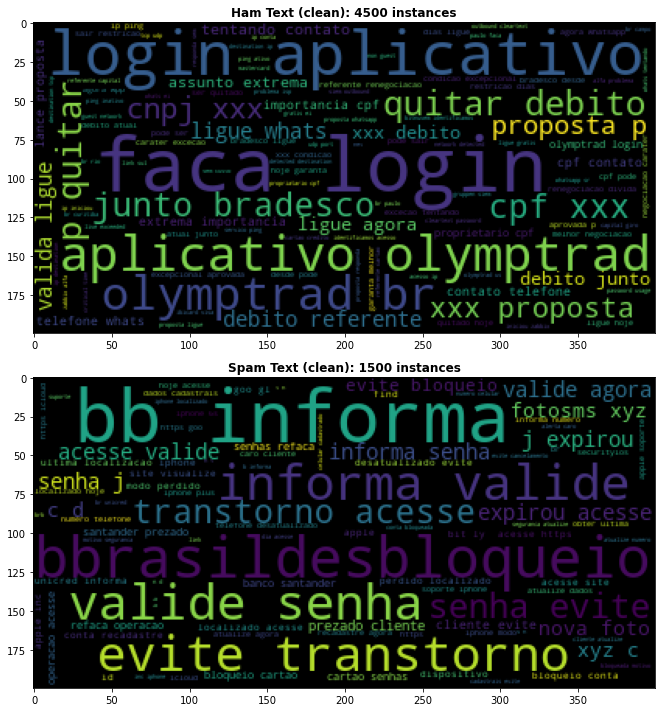

In [12]:
%%time

ham_wc = WordCloud().generate(" ".join(ham_bag))
spam_wc = WordCloud().generate(" ".join(spam_bag))

# Make figure.
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
axes = axes.flatten() 
axes[0].imshow(ham_wc) 
axes[1].imshow(spam_wc) 
axes[0].set_title(f"Ham Text (clean): {ham_index.size} instances", weight="bold")
axes[1].set_title(f"Spam Text (clean): {spam_index.size} instances", weight="bold")
plt.tight_layout()

- **Cleaning raw text:**
    - Remove special characters.
    - Remove multiple white spaces.
    - Convert all words to lower case.
    - Remove typical accents from Portuguese words.
    - Remove stop words, but maintain some of them that have negative meaning (nao, sem, nem).
    - Word clouds for ham and spam cleaned messages gives us a first visualization of the training data set.

## 3. Feature Engineering

**Ancillary tools for text manipulation.**

In [13]:
# Size of each SMS text.
def text_length(text):
    
    return len(text.split())

# Find digits in messages and return their counts.
def how_many_digits(text):
    
    return len(re.findall(pattern=r"\d", string=text))

### 3.1 Text Length

In [14]:
# New column with size information of clean SMSs.
df.insert(
    loc=df.shape[1] - 2, 
    column="SMS_CLEAN_LENGTH", 
    value=df["SMS_CLEAN"].map(text_length)
)

# Show it.
df.head()

,SMS,SMS_CLEAN,SMS_CLEAN_LENGTH,LABEL,TARGET
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,boleto referente parcelas atraso consorcio bb ...,18,blocked,1
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,050003da0202 iphone vtbqroy,3,blocked,1
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,060804cb5f0303 ps bancodobrasil seguranca gq,5,blocked,1
3,Atualizacao ainda nao foi executado em sua con...,atualizacao ainda nao executado conta evite bl...,12,blocked,1
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,0608042be40303 ps bancodobrasil seguranca cf,5,blocked,1


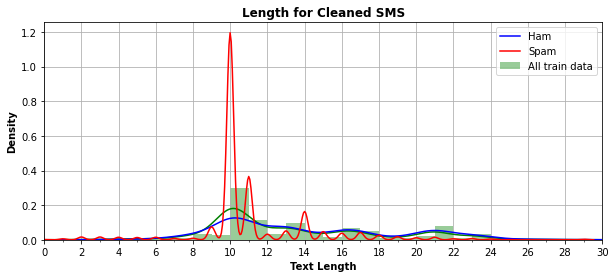

In [15]:
# Make figure.
plt.figure(figsize=(10, 4))
ax = plt.gca()
bins = np.arange(0, 31, 1)

# Data distribution.
sns.distplot(
    a=df.SMS_CLEAN_LENGTH,
    bins=bins,
    color="green",
    hist=True,
    ax=ax,
    label="All train data",
    kde_kws={"gridsize": 500}
)

# Ham!
sns.distplot(
    a=df.iloc[ham_index].SMS_CLEAN_LENGTH,
    color="blue",
    hist=False,
    ax=ax,
    label="Ham",
    kde_kws={"gridsize": 500}
)

# Spam!
sns.distplot(
    a=df.iloc[spam_index].SMS_CLEAN_LENGTH,
    color="red",
    hist=False,
    ax=ax,
    label="Spam",
    kde_kws={"gridsize": 500}
)

# Adjustments.
ax.set_title("Length for Cleaned SMS", weight="bold")
ax.set_ylabel("Density", weight="bold")
ax.set_xlabel("Text Length", weight="bold")
ax.legend(loc="upper right")
ax.set_xlim((0, 30))
ax.set_xticks(np.arange(0, 32, 2))
ax.set_xticks(np.arange(1, 31, 2), minor=True)
ax.grid()

### 3.2 Presence of Digits

In [16]:
# New column with number digits for clean SMSs.
df.insert(
    loc=df.shape[1] - 2, 
    column="SMS_CLEAN_DIGITS", 
    value=df["SMS_CLEAN"].map(how_many_digits)
)

# Show it.
df.head()

,SMS,SMS_CLEAN,SMS_CLEAN_LENGTH,SMS_CLEAN_DIGITS,LABEL,TARGET
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,boleto referente parcelas atraso consorcio bb ...,18,11,blocked,1
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,050003da0202 iphone vtbqroy,3,10,blocked,1
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,060804cb5f0303 ps bancodobrasil seguranca gq,5,11,blocked,1
3,Atualizacao ainda nao foi executado em sua con...,atualizacao ainda nao executado conta evite bl...,12,0,blocked,1
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,0608042be40303 ps bancodobrasil seguranca cf,5,12,blocked,1


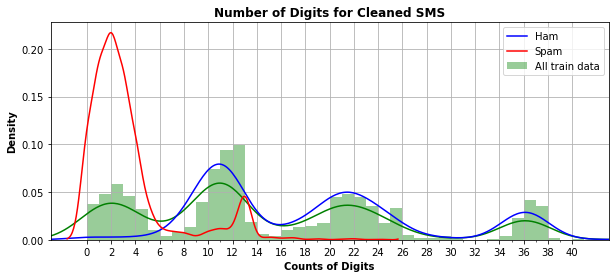

In [17]:
# Make figure.
plt.figure(figsize=(10, 4))
ax = plt.gca()
bins = np.arange(0, 64, 1)

# Data distribution.
sns.distplot(
    a=df.SMS_CLEAN_DIGITS,
    bins=bins,
    color="green",
    hist=True,
    ax=ax,
    label="All train data",
    kde_kws={"gridsize": 500}
)

# Ham!
sns.distplot(
    a=df.iloc[ham_index].SMS_CLEAN_DIGITS,
    color="blue",
    hist=False,
    ax=ax,
    label="Ham",
    kde_kws={"gridsize": 500}
)

# Spam!
sns.distplot(
    a=df.iloc[spam_index].SMS_CLEAN_DIGITS,
    color="red",
    hist=False,
    ax=ax,
    label="Spam",
    kde_kws={"gridsize": 500}
)

# Adjustments.
ax.set_title("Number of Digits for Cleaned SMS", weight="bold")
ax.set_ylabel("Density", weight="bold")
ax.set_xlabel("Counts of Digits", weight="bold")
ax.legend(loc="upper right")
ax.set_xlim((-3, 43))
ax.set_xticks(np.arange(0, 42, 2))
ax.set_xticks(np.arange(1, 41, 2), minor=True)
ax.grid()

### 3.3 Data Split

In [18]:
# Split proportions.
test_size = 0.20
train_size = 1 - test_size

# Total number of instances.
N = df.shape[0]

# Train-test split.
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df.drop(labels=["LABEL", "TARGET"], axis=1), 
    df["TARGET"], 
    stratify=df["TARGET"], 
    test_size=test_size
) 

# Information.
print(">>> Shape and percentual of instances:")
print(f"* Train:      {df_X_train.shape}; ({df_X_train.shape[0] / N * 100} %)")
print(f"* Test:       {df_X_test.shape}; ({df_X_test.shape[0] / N * 100} %)")

# More information.
print("\n>>> Train target proportions:"); print(df_y_train.value_counts() / df_y_train.size)
print("\n>>> Test target proportions:"); print(df_y_test.value_counts() / df_y_test.size)

>>> Shape and percentual of instances:
* Train:      (4800, 4); (80.0 %)
* Test:       (1200, 4); (20.0 %)

>>> Train target proportions:
0    0.75
1    0.25
Name: TARGET, dtype: float64

>>> Test target proportions:
0    0.75
1    0.25
Name: TARGET, dtype: float64


### 3.4 Scale Previous Numeric Features

In [19]:
# Only scaled numeric features.
features_numeric = ["SMS_CLEAN_LENGTH", "SMS_CLEAN_DIGITS"]

# Scaling of text length and number of digits.
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_X_train[features_numeric])

# Train numeric!
df_X_train_num = pd.DataFrame(
    data=scaler.transform(df_X_train[features_numeric]), 
    columns=features_numeric
)

# Test numeric! Avoid data leakage.
df_X_test_num = pd.DataFrame(
    data=scaler.transform(df_X_test[features_numeric]), 
    columns=features_numeric
)

### 3.5 Unigram Bag of Words 

In [20]:
# Ignore less than 5 occurrences.
bow = CountVectorizer(min_df=5)

# Fit on train and avoid data leakage.
bow.fit(df_X_train["SMS_CLEAN"].values)
bow_uni_train = bow.transform(df_X_train["SMS_CLEAN"].values)
bow_uni_test = bow.transform(df_X_test["SMS_CLEAN"].values)

# As a list.
unigram_features = bow.get_feature_names()

# Information.
print(">>> Unigrams for clean SMS messages:")
print(f"* Train:      {bow_uni_train.shape}")
print(f"* Test:       {bow_uni_test.shape}")

>>> Unigrams for clean SMS messages:
* Train:      (4800, 973)
* Test:       (1200, 973)


In [21]:
# Join unigram bag of words and scaled numeric features (train).
df_X_train_uni = pd.DataFrame(
    data=np.hstack(tup=(df_X_train_num.values, bow_uni_train.toarray())),
    columns=features_numeric + unigram_features
)

# Join unigram bag of words and scaled features (test).
df_X_test_uni = pd.DataFrame(
    data=np.hstack(tup=(df_X_test_num.values, bow_uni_test.toarray())),
    columns=features_numeric + unigram_features
)

# Show it.
print(">>> Final train data for unigram bag of words representation:")
print()
df_X_train_uni

>>> Final train data for unigram bag of words representation:



,SMS_CLEAN_LENGTH,SMS_CLEAN_DIGITS,00,000,001,003,01,011,02,03,...,windows,with,wpp,www,xxx,xyz,yamaha,you,your,zabbix
0,0.34375,0.380952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.31250,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.53125,0.396825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.31250,0.190476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.21875,0.174603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,0.31250,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4796,0.46875,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4797,0.40625,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4798,0.43750,0.539683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.6 Bigram Bag of Words 

In [22]:
# Ignore less than 5 occurrences.
bow = CountVectorizer(min_df=5, ngram_range=(1, 2))

# Fit on train and avoid data leakage.
bow.fit(df_X_train["SMS_CLEAN"].values)
bow_bi_train = bow.transform(df_X_train["SMS_CLEAN"].values)
bow_bi_test = bow.transform(df_X_test["SMS_CLEAN"].values)

# As a list.
bigram_features = bow.get_feature_names()

# Information.
print(">>> Unigrams for clean SMS messages:")
print(f"* Train:      {bow_bi_train.shape}")
print(f"* Test:       {bow_bi_test.shape}")

>>> Unigrams for clean SMS messages:
* Train:      (4800, 2128)
* Test:       (1200, 2128)


In [23]:
# Join bigram bag of words and scaled numeric features (train).
df_X_train_bi = pd.DataFrame(
    data=np.hstack(tup=(df_X_train_num.values, bow_bi_train.toarray())),
    columns=features_numeric + bigram_features
)

# Join bigram bag of words and scaled features (test).
df_X_test_bi = pd.DataFrame(
    data=np.hstack(tup=(df_X_test_num.values, bow_bi_test.toarray())),
    columns=features_numeric + bigram_features
)

# Show it.
print(">>> Final train data for bigram bag of words representation:")
print()
df_X_train_bi

>>> Final train data for bigram bag of words representation:



,SMS_CLEAN_LENGTH,SMS_CLEAN_DIGITS,00,00 00,00 41,00 42,000,000 xxx,001,003,...,yamaha motor,you,you are,your,your iphone,your login,your lost,zabbix,zabbix alfa,zabbix bgp
0,0.34375,0.380952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.31250,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.53125,0.396825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.31250,0.190476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.21875,0.174603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,0.31250,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4796,0.46875,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4797,0.40625,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4798,0.43750,0.539683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- **Feature engineering:**
    - We create two `numeric` features for clean text: (1) the number of words, or text length, and (2) the number of digits in the message.
    - These two new features show clear differences between ham and spam clean messages.
    - Stratified data split taking into account unbalanced classes: 80% (train-validation) and 20% test. 
    - Minimum-Maximum scaling for these two numeric features (just to avoid negative values).
    - Create bag of words using `unigram` and `bigram` features. 
    - All these features (numeric, unigram, and bigram) are good enough to obtain overall accurate results in machine learning models.

## 4 Machine Learning Models 

**Ancillary tools for plotting model results**

In [24]:
# Intercomparison of models.
models = {}
results = {}

# All intersting scores for comparing models.
def all_scores(model, X_true, y_true):
    
    # Spam is class 1.
    y_score = model.predict_proba(X_true)[:, 1]
    y_pred = model.predict(X_true)
    
    # Classification metrics.
    acc = accuracy_score(y_true, y_pred)
    bac = balanced_accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1s = f1_score(y_true, y_pred, zero_division=0) 
    auc = roc_auc_score(y_true, y_score)
    jac = jaccard_score(y_true, y_pred)
    scores = (acc, bac, pre, rec, f1s, auc, jac)

    return scores
    
# Receiver operating characteristic (ROC) curve.
def plot_roc(model, X_true, y_true, model_name="model"):
  
    # Spam is class 1.
    predicted_probs = model.predict_proba(X_true)[:, 1]
    fpr, tpr, _ = roc_curve(y_true, predicted_probs)
    auc = roc_auc_score(y_true, predicted_probs)
    
    # Make figure.
    plt.figure(figsize=(7.5, 5))
    plt.plot(fpr, tpr, label="Cross Validation ROC", color="blue", lw=1.5)
    plt.plot([0, 1], [0, 1], lw=1.5, ls="--", color="red", label="No skill")
    plt.xticks(ticks=np.arange(0, 1.1, 0.1))
    plt.yticks(ticks=np.arange(0, 1.1, 0.1))
    plt.title(
        model_name + "\n" + \
        "Receiver Operating Characteristic (ROC)\n",
        weight="bold"
    )
    plt.xlabel("False Positive Rate", weight="bold")
    plt.ylabel("True Positive Rate", weight="bold")
    plt.legend()
    plt.grid()

    # Text with results for classification metrics.
    scores = all_scores(model, X_true, y_true)
    text = \
    """
    Classification scores:  
    
    %.3f  -  Accuracy          
    %.3f  -  Bal. Accuracy 
    %.3f  -  Precision     
    %.3f  -  Recall 
    %.3f  -  F1 score         
    %.3f  -  AUC           
    %.3f  -  Jaccard      
    """ %(scores)
    
    plt.text(
        x=1.025, y=0.35, s=text, weight="bold", transform=plt.gca().transAxes
    )
    
# Confusion matrix.
def plot_confusion_matrix(model, X_true, y_true, model_name="model"):   
    
    # Predicted class and confusion matrix.
    y_pred = model.predict(X_true)
    C = confusion_matrix(y_true, y_pred, labels=[1, 0])
    df_C = pd.DataFrame(data=C, index=["spam", "ham"], columns=["spam", "ham"]).T
    scores = all_scores(model, X_true, y_true)
    
    # Make figure.
    plt.figure(figsize=(7.5, 5))
    
    # Confusion matrix.
    ax = sns.heatmap(
        data=df_C, 
        annot=True, 
        cmap=plt.cm.Greens, 
        fmt="d", 
        ax=plt.gca()
    )
    
    # Text with results for classification metrics.
    text = \
    """
    Classification scores:  
    
    %.3f  -  Accuracy          
    %.3f  -  Bal. Accuracy 
    %.3f  -  Precision     
    %.3f  -  Recall 
    %.3f  -  F1 score         
    %.3f  -  AUC           
    %.3f  -  Jaccard      
    """ %(scores)
    
    ax.collections[0].axes.text(
        x=1.25, y=0.35, s=text, weight="bold", transform=plt.gca().transAxes
    )
        
    # Adjustments.
    plt.gcf().suptitle(model_name, weight="bold")
    ax.set_title("Confusion matrix", weight="bold")
    ax.set_xlabel("Actual", weight="bold")
    ax.set_ylabel("Predicted", weight="bold")
    ax.collections[0].colorbar.set_label("Counts", weight="bold")
    ax.collections[0].axes.set_xticklabels(df_C.columns, weight="bold")
    ax.collections[0].axes.set_yticklabels(df_C.index, weight="bold")

### 4.1 Dummy Classifier (Most Frequent Class)

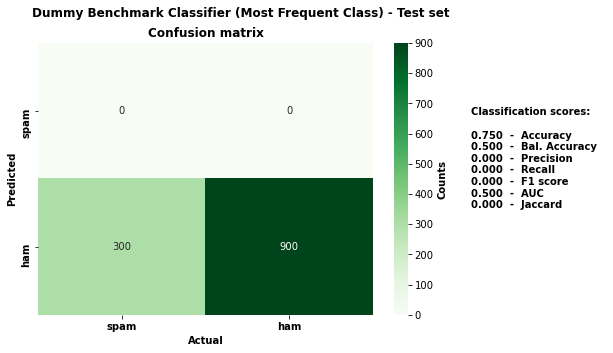

In [25]:
# Just a baseline.
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(df_X_train, df_y_train)

# Keep results.
results["dummy"] = all_scores(
    model=dummy, 
    X_true=df_X_test_num, 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=dummy, 
    X_true=df_X_test, 
    y_true=df_y_test,
    model_name="Dummy Benchmark Classifier (Most Frequent Class) - Test set"
)

### 4.2 Logistic Regression (Numeric)

In [26]:
%%time

# Logistic regression with numeric features only. Exhaustive search for the best model.
search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={"C": np.power(10, np.linspace(start=-6, stop=6, num=100))},
    scoring="balanced_accuracy",
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train_num, df_y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:    5.5s


CPU times: user 3.01 s, sys: 480 ms, total: 3.49 s
Wall time: 6.19 s


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.1s finished


In [27]:
# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df = pd.DataFrame(search.cv_results_)
print(df.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                         0.0176258
std_fit_time                         0.00167301
mean_score_time                      0.00402536
std_score_time                      0.000978077
param_C                                 10.7227
params                {'C': 10.722672220103231}
split0_test_score                      0.925694
split1_test_score                      0.936111
split2_test_score                        0.9125
split3_test_score                      0.931944
split4_test_score                      0.943056
mean_test_score                        0.929861
std_test_score                        0.0103563
rank_test_score                               1
split0_train_score                     0.930729
split1_train_score                     0.927778
split2_train_score                     0.934028
split3_train_score                     0.928819
split4_train_score                     0.926389
mean_train_score                       0.929549


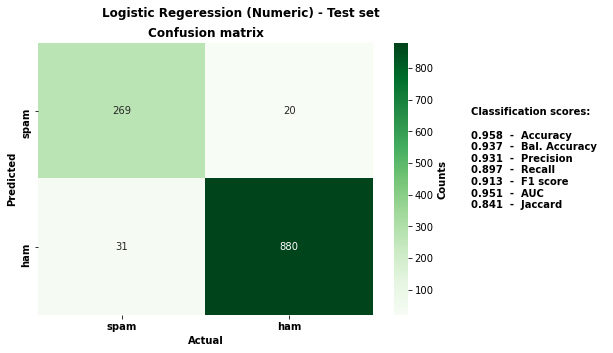

In [28]:
# Keep results.
models["logreg_num"] = search.best_estimator_
results["logreg_num"] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test_num, 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test_num, 
    y_true=df_y_test,
    model_name="Logistic Regeression (Numeric) - Test set"
)

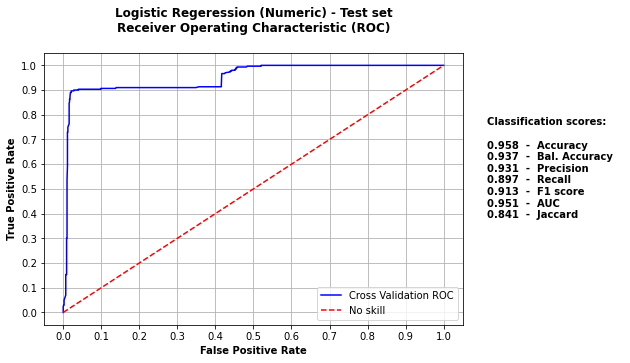

In [29]:
# Show results for test set.
plot_roc(
    model=search.best_estimator_, 
    X_true=df_X_test_num, 
    y_true=df_y_test,
    model_name="Logistic Regeression (Numeric) - Test set"
)

### 4.3 Logistic Regression (Numeric and Unigram)

In [30]:
%%time

# Logistic regression with numeric and unigram features. 
# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={"C": np.power(10, np.linspace(start=-6, stop=6, num=100))},
    scoring="balanced_accuracy",
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train_uni, df_y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:    7.8s


CPU times: user 6.55 s, sys: 544 ms, total: 7.09 s
Wall time: 13.9 s


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   13.7s finished


In [31]:
# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df = pd.DataFrame(search.cv_results_)
print(df.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                          1.09952
std_fit_time                         0.0876666
mean_score_time                      0.0351841
std_score_time                       0.0020292
param_C                                8.11131
params                {'C': 8.111308307896872}
split0_test_score                     0.995139
split1_test_score                     0.990972
split2_test_score                      0.99375
split3_test_score                     0.988889
split4_test_score                     0.993056
mean_test_score                       0.992361
std_test_score                      0.00219603
rank_test_score                              1
split0_train_score                    0.999479
split1_train_score                    0.999479
split2_train_score                    0.998958
split3_train_score                           1
split4_train_score                    0.998958
mean_train_score                      0.999375
std_train_score     

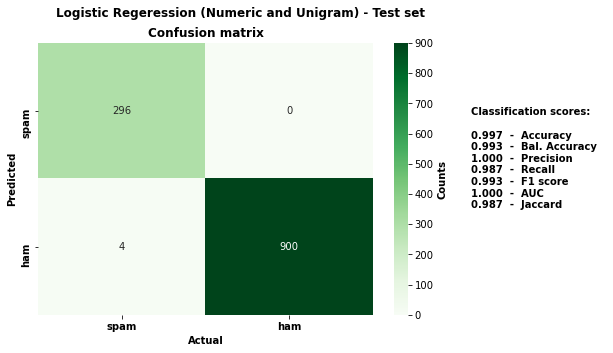

In [32]:
# Keep results.
models["logreg_num_uni"] = search.best_estimator_
results["logreg_num_uni"] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test_uni, 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test_uni, 
    y_true=df_y_test,
    model_name="Logistic Regeression (Numeric and Unigram) - Test set"
)

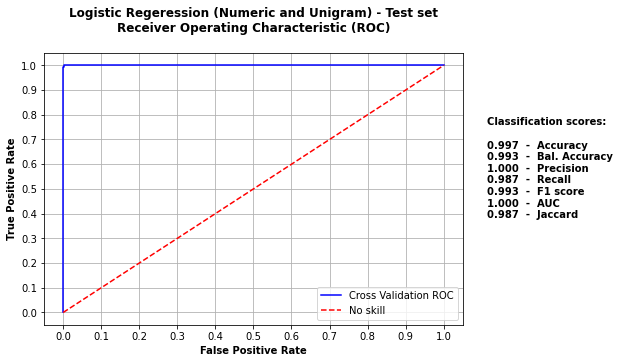

In [33]:
# Show results for test set.
plot_roc(
    model=search.best_estimator_, 
    X_true=df_X_test_uni, 
    y_true=df_y_test,
    model_name="Logistic Regeression (Numeric and Unigram) - Test set"
)

### 4.4 Logistic Regression (Numeric, Unigram, Bigram)

In [34]:
%%time

# Logistic regression with numeric, unigram and bigram features. 
# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={"C": np.power(10, np.linspace(start=-6, stop=6, num=100))},
    scoring="balanced_accuracy",
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train_bi, df_y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.4s finished


CPU times: user 11.9 s, sys: 756 ms, total: 12.7 s
Wall time: 28.8 s


In [35]:
# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df = pd.DataFrame(search.cv_results_)
print(df.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                           2.29747
std_fit_time                           0.118548
mean_score_time                       0.0679209
std_score_time                       0.00369007
param_C                                 43.2876
params                {'C': 43.287612810830616}
split0_test_score                      0.998611
split1_test_score                      0.997222
split2_test_score                      0.990972
split3_test_score                      0.995139
split4_test_score                      0.993056
mean_test_score                           0.995
std_test_score                       0.00275687
rank_test_score                               1
split0_train_score                     0.999826
split1_train_score                     0.999826
split2_train_score                     0.999826
split3_train_score                            1
split4_train_score                            1
mean_train_score                       0.999896


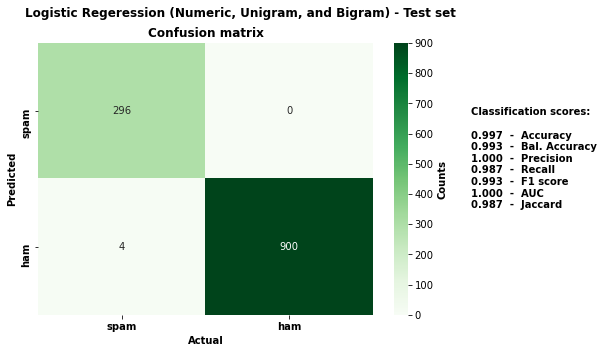

In [36]:
# Keep results.
# Keep results.
models["logreg_num_uni_big"] = search.best_estimator_
results["logreg_num_uni_big"] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test_bi, 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test_bi, 
    y_true=df_y_test,
    model_name="Logistic Regeression (Numeric, Unigram, and Bigram) - Test set"
)

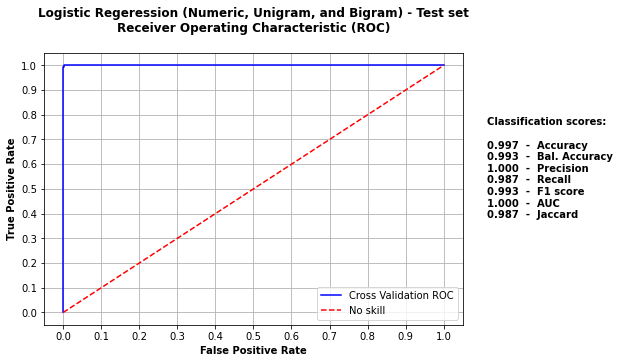

In [37]:
# Show results for test set.
plot_roc(
    model=search.best_estimator_, 
    X_true=df_X_test_bi, 
    y_true=df_y_test,
    model_name="Logistic Regeression (Numeric, Unigram, and Bigram) - Test set"
)

### 4.5 Naive Bayes Classifier (Unigram)

In [38]:
%%time

# Naive Bayes classifier with unigram features only. 
# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid={"alpha": np.power(10, np.linspace(start=-6, stop=6, num=100))},
    scoring="balanced_accuracy",
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train_uni.drop(features_numeric, axis=1), df_y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:    2.9s


CPU times: user 3 s, sys: 272 ms, total: 3.27 s
Wall time: 3.89 s


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.7s finished


In [39]:
# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df = pd.DataFrame(search.cv_results_)
print(df.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                               0.0468566
std_fit_time                               0.00815247
mean_score_time                             0.0190819
std_score_time                             0.00537964
param_alpha                                 0.0305386
params                {'alpha': 0.030538555088334186}
split0_test_score                            0.997917
split1_test_score                            0.997917
split2_test_score                            0.994444
split3_test_score                            0.994444
split4_test_score                            0.989583
mean_test_score                              0.994861
std_test_score                             0.00306186
rank_test_score                                     1
split0_train_score                           0.994271
split1_train_score                           0.994444
split2_train_score                           0.996007
split3_train_score                        

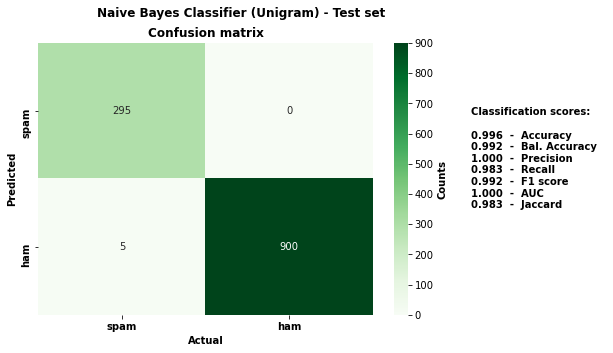

In [40]:
# Keep results.
models["naive_uni"] = search.best_estimator_
results["naive_uni"] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test_uni.drop(features_numeric, axis=1), 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test_uni.drop(features_numeric, axis=1), 
    y_true=df_y_test,
    model_name="Naive Bayes Classifier (Unigram) - Test set"
)

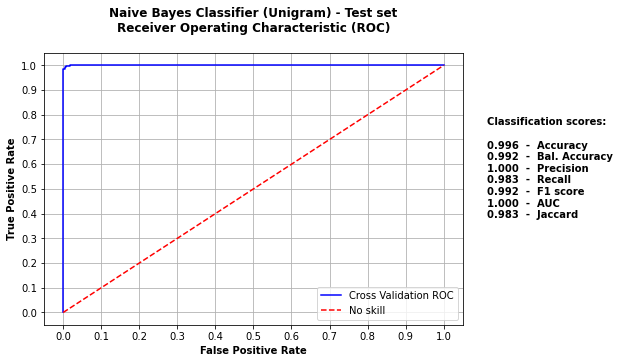

In [41]:
# Show results for test set.
plot_roc(
    model=search.best_estimator_, 
    X_true=df_X_test_uni.drop(features_numeric, axis=1),
    y_true=df_y_test,
    model_name="Naive Bayes Classifier (Unigram) - Test set"
)

### 4.6 Naive Bayes Classifier (Unigram and Bigram)

In [42]:
%%time

# Naive Bayes classifier with unigram and bigram features. 
# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid={"alpha": np.power(10, np.linspace(start=-6, stop=6, num=100))},
    scoring="balanced_accuracy",
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train_bi.drop(features_numeric, axis=1), df_y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:    3.8s


CPU times: user 3.76 s, sys: 532 ms, total: 4.29 s
Wall time: 5.14 s


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.9s finished


In [43]:
# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df = pd.DataFrame(search.cv_results_)
print(df.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                             0.108734
std_fit_time                             0.0198727
mean_score_time                           0.037351
std_score_time                          0.00960514
param_alpha                              0.0932603
params                {'alpha': 0.093260334688322}
split0_test_score                          0.99375
split1_test_score                         0.989583
split2_test_score                         0.998611
split3_test_score                         0.992361
split4_test_score                         0.998611
mean_test_score                           0.994583
std_test_score                          0.00355186
rank_test_score                                  1
split0_train_score                         0.99566
split1_train_score                        0.996181
split2_train_score                        0.994097
split3_train_score                        0.995313
split4_train_score                        

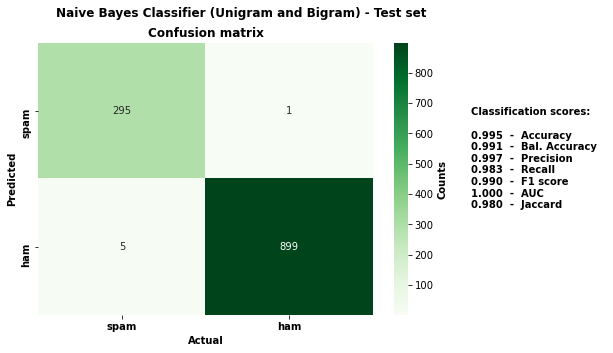

In [44]:
# Keep results.
models["naive_uni_big"] = search.best_estimator_
results["naive_uni_big"] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test_bi.drop(features_numeric, axis=1), 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test_bi.drop(features_numeric, axis=1), 
    y_true=df_y_test,
    model_name="Naive Bayes Classifier (Unigram and Bigram) - Test set"
)

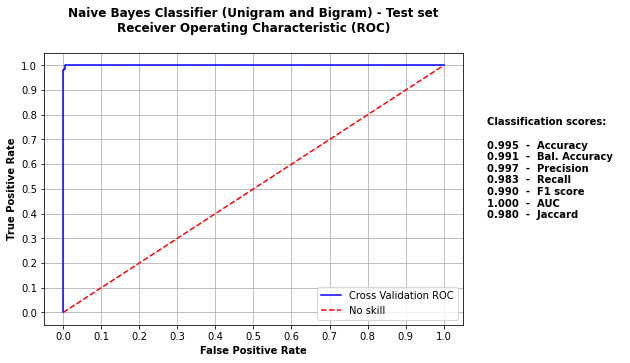

In [45]:
# Show results for test set.
plot_roc(
    model=search.best_estimator_, 
    X_true=df_X_test_bi.drop(features_numeric, axis=1),
    y_true=df_y_test,
    model_name="Naive Bayes Classifier (Unigram and Bigram) - Test set"
)

- **Machine Learning Models:**
    - We create a benchmark model: a `Dummy Classifier` that give as result the most frequent class occurrence in training set (just to see the score values of a simple enough model in this unbalanced classification).
    - Three `Logistic Regression` models: (1) only numeric features, (2) numeric and unigram features and (3), numeric, unigram and bigram features.
    - Two `Naive Bayes Classifiers`: (1) only unigram features and (2) unigram and bigram features.
    - Logistic Regression and Naive Bayes models are trained with exhaustive hyperparameter grid search using 5-fold stratified cross validation (because of unbalanced classes).
    - The scoring metric for searching the best models in this hyperparameter tuning is balanced accuracy (because of unbalanced classes).
    - For each model we plot confusion matrix and Receiver Operating Characteristic (ROC) curve. 
    - Compare models using seven scores: (1) accuracy, (2) balanced accuracy, (3) precision, (4) recall, (5) F1-Score, (6) area under ROC curve, and (7) Jaccard score.

## 5 Conclusions

### 5.1 Compare Models

In [46]:
# Head of table with all results.
final_table = PrettyTable(
    field_names=[
        "Tuned Model and Features", 
        "Acc.",
        "Bal. Acc.",
        "Precision",
        "Recall",
        "F1 Score",
        "AUC",
        "Jaccard"
    ], 
    title="Overall Performances of Machine Learning Models on Test Data"
)
final_table.align = "l"

# Fill this table with performances of trained models.
final_table.add_row(
    ["* Dummy Classifier\n(Most Frequent Class)"] + \
    ["%.4f" %(m) for m in results["dummy"]]
)
final_table.add_row(
    ["* Logistic Regression\n(Numeric)"] + \
    ["%.4f" %(m) for m in results["logreg_num"]]
)
final_table.add_row(
    ["* Logistic Regression\n(Numeric, Unigram)"] + \
    ["%.4f" %(m) for m in results["logreg_num_uni"]]
)
final_table.add_row(
    ["* Logistic Regression\n(Numeric, Unigram, Bigram)"] + \
    ["%.4f" %(m) for m in results["logreg_num_uni_big"]]
)
final_table.add_row(
    ["* Naive Bayes\n(Unigram)"] + \
    ["%.4f" %(m) for m in results["naive_uni"]]
)
final_table.add_row(
    ["* Naive Bayes\n(Bigram)"] + \
    ["%.4f" %(m) for m in results["naive_uni_big"]]
)

print(final_table)

+----------------------------------------------------------------------------------------------------+
|                    Overall Performances of Machine Learning Models on Test Data                    |
+----------------------------+--------+-----------+-----------+--------+----------+--------+---------+
| Tuned Model and Features   | Acc.   | Bal. Acc. | Precision | Recall | F1 Score | AUC    | Jaccard |
+----------------------------+--------+-----------+-----------+--------+----------+--------+---------+
| * Dummy Classifier         | 0.7500 | 0.5000    | 0.0000    | 0.0000 | 0.0000   | 0.5000 | 0.0000  |
| (Most Frequent Class)      |        |           |           |        |          |        |         |
| * Logistic Regression      | 0.9575 | 0.9372    | 0.9308    | 0.8967 | 0.9134   | 0.9513 | 0.8406  |
| (Numeric)                  |        |           |           |        |          |        |         |
| * Logistic Regression      | 0.9967 | 0.9933    | 1.0000    | 0.9867 | 

### 5.2 Apply Best Model to Validation Data

In [47]:
%%time

# Load raw validation data set.
df_validation = pd.read_csv("./validation.csv") 
df_validation_raw = df_validation.copy()

# List of lists with clean SMSs.
clean_SMS = []

# Loop oves SMSs.
for text in tqdm(df_validation.SMS.values):
    
    # Standardize text.
    clean_text = filter_text(text)
    clean_text = no_stop_words(clean_text)
    
    # Remove residual non-alphanumeric words.
    tmp = []
    for word in clean_text.split():
        if word.isalnum():
            tmp.append(word)

    # Final text.
    clean_SMS.append(" ".join(tmp))
    
# New columns.
df_validation["SMS_CLEAN"] = clean_SMS
df_validation = df_validation[["SMS", "SMS_CLEAN"]]

# New column with size information of clean SMSs.
df_validation.insert(
    loc=df_validation.shape[1] - 2, 
    column="SMS_CLEAN_LENGTH", 
    value=df_validation["SMS_CLEAN"].map(text_length)
)

# New column with size information of clean SMSs.
df_validation.insert(
    loc=df_validation.shape[1] - 2, 
    column="SMS_CLEAN_DIGITS", 
    value=df_validation["SMS_CLEAN"].map(how_many_digits)
)

# Scale numeric features.
df_validation[features_numeric] = scaler.transform(df_validation[features_numeric])
    
# Ignore less than 5 occurrences.
bow = CountVectorizer(min_df=5)

# Fit on train and avoid data leakage.
bow.fit(df_X_train["SMS_CLEAN"].values)
bow_uni_val = bow.transform(df_validation["SMS_CLEAN"].values)

# Join unigram bag of words and scaled numeric features (validation).
df_X_validation_uni = pd.DataFrame(
    data=np.hstack(tup=(df_validation[features_numeric].values, bow_uni_val.toarray())),
    columns=features_numeric + unigram_features
)
    
# Make preditions with our best model.
y_pred_val = models["logreg_num_uni"].predict(df_X_validation_uni)
y_pred_val_labels = ["spam" if i==1 else "ham" for i in y_pred_val]
df_y_pred_val_labels = pd.Series(y_pred_val_labels, name="PREDICTED_LABEL")
print("\n>>> Predictions:")
print(df_y_pred_val_labels.value_counts())
print("\n>>> Predictions normalized:")
print(df_y_pred_val_labels.value_counts(normalize=True) * 100)
print()

# Export results.
pd.concat(objs=(df_validation_raw, df_y_pred_val_labels), axis=1).to_csv(
    path_or_buf="./validation_filled_alex.csv", index=False
)

100%|██████████| 2000/2000 [00:01<00:00, 1205.75it/s]



>>> Predictions:
ham     1511
spam     489
Name: PREDICTED_LABEL, dtype: int64

>>> Predictions normalized:
ham     75.55
spam    24.45
Name: PREDICTED_LABEL, dtype: float64

CPU times: user 1.8 s, sys: 104 ms, total: 1.9 s
Wall time: 1.84 s


- **Conclusions:**
    - When we add bigram features to the models already using unigram and/or numeric features, they show no improvement in any of the selected scores.
    - By visual inspection of the table comparing overall scores of the models on test data, we can see that our best (and simplest) model is Logistic Regression (with numeric and unigram features). 
    - According to our predictions, we note that the validation data show similar unbalanced classes (25% spam and 75% ham).
    - Due to the overall good performance of our simple feature engineering and modeling, we did not consider it necessary to try more advanced methods from Natural Language Processing (word2vec, Recurrent Neural Networks, BERT, etc).